# Churn - Modelagem - Random Forest 

# Índice

1. [Bibliotecas](#Bibliotecas)


2. [Tratamento de Base](#Tratamento-de-Base)  

    2.1. [Metadados do DataFrame](#Metadados-do-DataFrame)
    
    2.2. [Binarização das variáveis](#Binarização-das-variáveis)
    

3. [Seleção das Variáveis](#Seleção-das-Variáveis)  

    3.1. [Variáveis Thiago](#Variáveis-Thiago)

4. [Modelagem - Random Forest](#Modelagem---Random-Forest)  

    4.1. [Escolha dos melhores parâmetros do modelo a partir do f1-score, precisão e recall](#Escolha-dos-melhores-parâmetros-do-modelo-a-partir-do-f1-score,-precisão-e-recall)
    
    4.2. [Parâmetros inseridos na função](#Parâmetros-inseridos-na-função)
    
    4.3. [DataFrame com a performance dos modelos, obtidas da função 'teste de parâmetros'](#DataFrame-com-a-performance-dos-modelos,-obtidas-da-função-'teste-de-parâmetros')


5. [Resultados](#Resultados)  

    5.1. [Função para criação da Matriz de Confusão](#Função-para-criação-da-Matriz-de-Confusão)
    
    5.2. [Matriz de Confusão com resultaos do Modelo para o corte em 50% da prob. de Churn](#Matriz-de-Confusão-com-resultaos-do-Modelo-para-o-corte-em-50%-da-prob.-de-Churn)
    
    5.3. [Importância das Variáveis](#Importância-das-Variáveis)
    
    5.4. [Teste para diferentes limiares da probabilidade de churn](#Teste-para-diferentes-limiares-da-probabilidade-de-churn)
        
    5.4.1. [Corte em 40% da 'predict_proba'](#Corte-em-40%-da-'predict_proba')
    
    5.4.2. [Corte em 60%](#Corte-em-60%)
    
    5.4.3. [Corte em 70%](#Corte-em-70%)
    
    5.4.4. [Corte em 80%](#Corte-em-80%)
    
    5.4.5. [Corte em 90%](#Corte-em-90%)
    
    5.5. [Distribuição da população 'não churn' em relação à probabilidade](#Distribuição-da-população-'não-churn'-em-relação-à-probabilidade)
    
    5.6. [Distribuição da população 'churn' em relação à probabilidade](#Distribuição-da-população-'churn'-em-relação-à-probabilidade)
    
    5.7. [Relação entre Recall e Precisão do Modelo](#Relação-entre-Recall-e-Precisão-do-Modelo)
    
    5.8. [Relação entre número de chutes e Churns](#Relação-entre-número-de-chutes-e-Churns)
    

6. [Apêndice](#Apêndice)


## Bibliotecas

[Índice](#Índice)

In [1]:
import numpy as np
import pandas as pd
import math
import time
from matplotlib import pyplot as plt
from pylab import rcParams
import matplotlib.ticker as ticker
import seaborn as sns 

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split 
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
pd.__version__

'0.23.4'

## Tratamento de Base

* Importa a base de Churn separada pela Safra

[Índice](#Índice)

In [4]:
Data_Churn_s1 = pd.read_csv('Churn_safra1.csv',sep=';')

### Metadados do DataFrame

* Cria um novo DataFrame que contem as características da base, descrevendo as variáveis, os campos e o tipo de campo.
         Ex:    Features	 Role	 Level	    Keep	 Tipo	   Cardinality
             	TED_VL_m1	input	interval	True	float64 	37524
                
                
                
[Índice](#Índice)                

In [5]:
def AjusteMetadados(dataframe): 

    train = dataframe
    # Verifica os tipos de variáveis presentes na tabela de treino
    t = []
    for i in train.columns:
            t.append(train[i].dtype)

    n = []
    for i in train.columns:
            n.append(i)

    aux_t = pd.DataFrame(data=t,columns=["Tipos"])
    aux_n = pd.DataFrame(data=n,columns=["Features"])
    df_tipovars = pd.concat([aux_n, aux_t], axis=1, join_axes=[aux_n.index])

    data = []
    for f in train.columns:

        # Definindo o papel das variáveis:
        if f == 'churn':
            role = 'target'
        elif f == 'id':
            role = 'id'
        else:
            role = 'input'

        # Definindo o tipo das variáveis: nominal, ordinal, binary ou interval
        if f == 'target':
            level = 'binary'
        if train[f].dtype == 'object' or f == 'id': 
            level = 'nominal'
        elif train[f].dtype in ['float','float64'] :
            level = 'interval'
        elif train[f].dtype in ['int','int64'] :
            level = 'ordinal'
        else:
            level = 'other'

        # Todas variáveis são incializadas com keep exceto o id
        keep = True
        if f == 'id':
            keep = False

        # Definindo o tipo das variáveis da tabela de entrada
        dtype = train[f].dtype

        # Criando a lista com todo metadados
        f_dict = {
            'Features': f,
            'Role': role,
            'Level': level,
            'Keep': keep,
            'Tipo': dtype
        }
        data.append(f_dict)

    meta = pd.DataFrame(data, columns=['Features', 'Role', 'Level', 'Keep', 'Tipo'])

    # Quantidade de domínios distintos para cada cariável do tipo ordinal e nominal
    card = []

    v = train.columns
    for f in v:
        dist_values = train[f].value_counts().shape[0]
        f_dict = {
                'Features': f,
                'Cardinality': dist_values
            }
        card.append(f_dict)

    card = pd.DataFrame(card, columns=['Features', 'Cardinality'])

    metadados_train = pd.merge(meta, card, on='Features')

    return metadados_train 

In [6]:
metadados = AjusteMetadados(Data_Churn_s1)
metadados

Features    Role     Level  Keep     Tipo  Cardinality
0                   churn  target     other  True     bool            2
1               TED_VL_m1   input  interval  True  float64        37524
2               TED_VL_m2   input  interval  True  float64        38840
3               TED_VL_m3   input  interval  True  float64        37078
4               TED_VL_m4   input  interval  True  float64        38442
5                TED_Q_m1   input   ordinal  True    int64          143
6                TED_Q_m2   input   ordinal  True    int64          168
7                TED_Q_m3   input   ordinal  True    int64          161
8                TED_Q_m4   input   ordinal  True    int64          166
9              MEDIANA_m1   input  interval  True  float64        30644
10             MEDIANA_m2   input  interval  True  float64        31455
11             MEDIANA_m3   input  interval  True  float64        29863
12             MEDIANA_m4   input  interval  True  float64        30758
13             TED_Q_m1_T   input   ordinal  True    int64           40
14             TED_Q_m2_T   input   ordinal  True    int64           43
15             TED_Q_m3_T   input   ordinal  True    int64           40
16             TED_Q_m4_T   input   ordinal  True    int64           41
17             TED_Q_m1_0   input   ordinal  True    int64           82
18             TED_Q_m1_1   input   ordinal  True    int64           95
19             TED_Q_m1_2   input   ordinal  True    int64           43
20             TED_Q_m1_3   input   ordinal  True    int64           32
21             TED_Q_m1_4   input   ordinal  True    int64           48
22             TED_Q_m1_5   input   ordinal  True    int64           27
23             TED_Q_m1_6   input   ordinal  True    int64           27
24             TED_Q_m1_7   input   ordinal  True    int64           21
25             TED_Q_m2_0   input   ordinal  True    int64           84
26             TED_Q_m2_1   input   ordinal  True    int64          103
27             TED_Q_m2_2   input   ordinal  True    int64           49
28             TED_Q_m2_3   input   ordinal  True    int64           41
29             TED_Q_m2_4   input   ordinal  True    int64           43
..                    ...     ...       ...   ...      ...          ...
162   Saldo_Medio_CAMBIAL   input  interval  True  float64         1207
163       Resgate_CAMBIAL   input  interval  True  float64          242
164         Aplic_CAMBIAL   input  interval  True  float64           71
165       Saldo_Medio_CDB   input  interval  True  float64       331824
166           Resgate_CDB   input  interval  True  float64       165214
167             Aplic_CDB   input  interval  True  float64        33718
168  Saldo_Medio_DEBENTUR   input  interval  True  float64         1192
169      Resgate_DEBENTUR   input  interval  True  float64          232
170        Aplic_DEBENTUR   input  interval  True  float64            6
171  Saldo_Medio_HIPERFUN   input  interval  True  float64       102216
172      Resgate_HIPERFUN   input  interval  True  float64        23913
173        Aplic_HIPERFUN   input  interval  True  float64         5866
174       Saldo_Medio_LCA   input  interval  True  float64         6241
175           Resgate_LCA   input  interval  True  float64         8347
176             Aplic_LCA   input  interval  True  float64            7
177       Saldo_Medio_LCI   input  interval  True  float64        35260
178           Resgate_LCI   input  interval  True  float64         4252
179             Aplic_LCI   input  interval  True  float64         6660
180        Saldo_Medio_LF   input  interval  True  float64         1117
181            Resgate_LF   input  interval  True  float64          136
182              Aplic_LF   input  interval  True  float64           42
183  Saldo_Medio_MULTIMER   input  interval  True  float64        25544
184      Resgate_MULTIMER   input  interval  True  float64         5042
185        Aplic_MULTIMER   input  interval  True  float6

### Trabalhando na variável Estados (Não foi utilizado)

Aqui as variáveis e segmentos foram separados de forma manual.
A idéia para trablhos futuros e agrupá-los através de uma árvore de decisões ou de um processo de clusterização.

In [59]:
Data_Churn_s1['LISTAESTADOS'] = Data_Churn_s1['ESTADO'].isin(['AC', 'AP', 'GO', 'MT', 'RJ', 'TO', 'DF', 'SE', 'PE', 'MA']).astype(int)
Data_Churn_s1['SEGMENTOS'] = Data_Churn_s1['DS_SEGMENTO_CLIENTE'].isin(['Prime', 'Prime - Espaco Prime', 'Prime - Espaco Prime - NIKKEI']).astype(int) 

In [39]:
var_Estado = Data_Churn_s1[['ESTADO']]
var_Estado.columns

ESTADO
0         NaN
1          RS
2          PR
3          BA
4          MG
5          RS
6          RJ
7          MG
8          RO
9          RJ
10         RJ
11         MG
12         SP
13         RJ
14        NaN
15         RS
16         RJ
17         BA
18         DF
19         RJ
20         SP
21         RS
22         DF
23         SP
24         PE
25         PR
26         PA
27         RJ
28         MA
29         PE
...       ...
751680     SP
751681     SP
751682     BA
751683     MG
751684     MT
751685     BA
751686     SP
751687     MG
751688     MS
751689     RS
751690     RJ
751691     MG
751692     RS
751693     RJ
751694     SP
751695     PA
751696     SP
751697     MG
751698     SP
751699     RS
751700     SP
751701     SP
751702     RS
751703     SP
751704     RS
751705     SP
751706     RJ
751707     RS
751708     SP
751709     MA

[751710 rows x 1 columns]

In [25]:
Var_Estados_bin = pd.get_dummies(var_Estado['ESTADO'], dummy_na=True,  drop_first=True)

In [44]:
estados = list(Var_Estados_bin.columns)

### Random Forest com a variável 'Estado'

In [30]:
x_train, x_test, y_train, y_test = train_test_split(Var_Estados_bin, Data_Churn_s1['churn'], test_size = 0.3, random_state = 0)     
rf = RandomForestClassifier(n_estimators=200, 
                            max_depth=4,
                            oob_score=True, 
                            class_weight='balanced').fit(x_train, y_train) 

predicted = rf.predict(x_test)
classif_report = metrics.classification_report(y_test,predicted) 
f1score = metrics.f1_score(y_test,predicted)
accuracy = metrics.accuracy_score(y_test,predicted)
precision = metrics.precision_score(y_test,predicted)
recall = metrics.recall_score(y_test,predicted)
confusion = metrics.confusion_matrix(y_test,rf.predict(x_test))
TN, FP    = confusion[0, 0], confusion[0, 1]
FN, TP    = confusion[1, 0], confusion[1, 1]
spec = round(TN / float(TN + FP),3)
sens = round(TP / float(TP + FN),3)
df_var_estados = pd.DataFrame({'Grupo': 'f1-score_full', 'f1-score':[f1score],'accuracy':[accuracy],'prec.':[precision],'recall':[recall],'TN':[TN], 'FP':[FN], 'FN':[FP], 'TP':[TP],'specif.':[spec], 'sens':[sens]})


In [45]:
importancia = list(rf.feature_importances_)

In [58]:
agrupa_estados = pd.DataFrame(data=[estados], columns = 'Estados')

AssertionError: 7 columns passed, passed data had 27 columns

In [55]:
agrupa_estados

0
0    AL
1    AM
2    AP
3    BA
4    CE
5    DF
6    ES
7    GO
8    MA
9    MG
10   MS
11   MT
12   PA
13   PB
14   PE
15   PI
16   PR
17   RJ
18   RN
19   RO
20   RR
21   RS
22   SC
23   SE
24   SP
25   TO
26  NaN

In [9]:
Data_Churn_s1['churn'].value_counts(True)

False    0.977341
True     0.022659
Name: churn, dtype: float64

### Binarização das variáveis

* Transforma as variáveis categóricas da base em variáveis binárias

[Índice](#Índice)

In [214]:
# Transforma Variáveis Categóricas em binárias (Dummies)
binarias = ["IN_SEXO","DESC_IMV","SITUACAO_IMV","CSIT_PNHOR_HIPOT"] 
Data_Churn_s1 = pd.get_dummies(Data_Churn_s1, columns=binarias, dummy_na=True,  drop_first=True) 

## Seleção das Variáveis

[Índice](#Índice)

### Variáveis Thiago

* Obtidas pelo XGBoost, selecionadas através da 'importância'

* Variáveis utilizadas de fato no modelo entregue, geradas pelo XGBoost (Thiago)

[Índice](#Índice)

In [10]:
Data_Churn = pd.read_csv('safra1_normal.csv',sep=',')

In [6]:
Data_Churn.drop('Unnamed: 0', axis = 1, inplace = True)

In [7]:
Var = list(Data_Churn.columns)

In [8]:
Var.remove('churn')

In [9]:
Var

['VR_RENDA',
 'TED_VL_TOTAL',
 'Saldo_Medio_RENDAFI',
 'TEMPO_MOV',
 'Saldo_Medio_CDB',
 'QTD_CONTAS',
 'MIN_CONTA',
 'MEDIANA_m4',
 'MEDIANA_m1',
 'Resgate_RENDAFI',
 'FOLHA_VL_total',
 'SOMA_REST',
 'MEDIANA_m3',
 'VL_TOTAL_REST',
 'Resgate_CDB',
 'VL_MIN_REST',
 'CD_CATEGORIA_PROFISSIONAL',
 'Saldo_Medio_HIPERFUN',
 'CD_ESTADO_CIVIL',
 'ANOS_COM_RESTRITIVO',
 'MEDIANA_m2',
 'Saldo_Medio_ACOES',
 'TED_Q_m4_T',
 'Saldo_Medio_MULTIMER',
 'Saldo_Medio_OUTROS']

## Modelagem - Random Forest

[Índice](#Índice)

In [20]:
x_train, x_test, y_train, y_test = train_test_split(Data_Churn[Var], Data_Churn['churn'], test_size = 0.3, random_state = 0)     

### Escolha dos melhores parâmetros do modelo a partir do f1-score, precisão e recall

[Índice](#Índice)

* Para esta etapa, é necessário rodar a [Função Teste de Parâmetros](#Função-Teste-de-Parâmetros) antes de proseguir.

In [119]:
df_parametros = pd.DataFrame()
df_parametros_sum = pd.DataFrame()

### Parâmetros inseridos na função

* Neste caso, alteramos os parâmetros: 
    * Número de estimadores
    * Profundidade das árvores
    * Critério de quebra da árvore

[Índice](#Índice)

In [120]:
n_estimadores = [10, 20, 30, 50, 100, 200, 300, 500]
profundidade = [3, 4, 5, 7, 9, 10, 12, 20]
criterio = ['gini', 'entropy']

### DataFrame com a performance dos modelos, obtidas da função 'teste de parâmetros'

[Índice](#Índice)

In [121]:
for i in criterio:
    for j in profundidade:
        for k in n_estimadores:
            df_parametros = teste_parametros(k,j,i)
            df_parametros_sum = pd.concat([df_parametros_sum,df_parametros])

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:497: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.

In [122]:
df_parametros_sum.to_csv('df_parametros_sum.csv')

In [13]:
df_parametros_sum = pd.read_csv('df_parametros_sum.csv')

In [15]:
df_parametros_sum.drop('Unnamed: 0', axis=1, inplace = True)

In [17]:
df_parametros_sum

Estimadores  Profundidade Criterio  f1-score  Log_loss     prec.  \
0             10             3     gini  0.112230  8.286870  0.061311   
1             20             3     gini  0.113973  7.991730  0.062465   
2             30             3     gini  0.106264  9.303087  0.057502   
3             50             3     gini  0.114896  7.633795  0.063249   
4            100             3     gini  0.115491  7.495491  0.063691   
5            200             3     gini  0.110193  8.607894  0.060003   
6            300             3     gini  0.110564  8.629642  0.060189   
7            500             3     gini  0.110493  8.500222  0.060233   
8             10             4     gini  0.105893  9.662861  0.057128   
9             20             4     gini  0.106725  9.488871  0.057656   
10            30             4     gini  0.108971  9.154675  0.059031   
11            50             4     gini  0.110362  8.975784  0.059876   
12           100             4     gini  0.111242  8.766261  0.060471   
13           200             4     gini  0.110477  8.903646  0.059979   
14           300             4     gini  0.111760  8.484447  0.060926   
15           500             4     gini  0.111142  8.684474  0.060467   
16            10             5     gini  0.115511  8.340783  0.063044   
17            20             5     gini  0.113630  8.635463  0.061836   
18            30             5     gini  0.111336  8.870410  0.060460   
19            50             5     gini  0.108661  9.322233  0.058776   
20           100             5     gini  0.111685  8.790461  0.060695   
21           200             5     gini  0.112482  8.693817  0.061182   
22           300             5     gini  0.112634  8.687844  0.061267   
23           500             5     gini  0.111976  8.810984  0.060838   
24            10             7     gini  0.118468  8.064329  0.064841   
25            20             7     gini  0.116920  8.474645  0.063712   
26            30             7     gini  0.118892  8.186091  0.064979   
27            50             7     gini  0.118706  8.171082  0.064890   
28           100             7     gini  0.119784  8.089907  0.065533   
29           200             7     gini  0.119040  8.160973  0.065077   
..           ...           ...      ...       ...       ...       ...   
98            30             9  entropy  0.130163  7.183046  0.071977   
99            50             9  entropy  0.131785  6.974442  0.073090   
100          100             9  entropy  0.129429  7.308178  0.071447   
101          200             9  entropy  0.130283  7.185650  0.072039   
102          300             9  entropy  0.130324  7.234202  0.072010   
103          500             9  entropy  0.130596  7.186262  0.072209   
104           10            10  entropy  0.134330  6.494591  0.075082   
105           20            10  entropy  0.134910  6.778550  0.075030   
106           30            10  entropy  0.135091  6.652346  0.075289   
107           50            10  entropy  0.135725  6.686654  0.075592   
108          100            10  entropy  0.137136  6.639787  0.076425   
109          200            10  entropy  0.137012  6.635192  0.076363   
110          300            10  entropy  0.136587  6.688186  0.076061   
111          500            10  entropy  0.136015  6.711007  0.075719   
112           10            12  entropy  0.145598  5.558017  0.082878   
113           20            12  entropy  0.146871  5.562152  0.083576   
114           30            12  entropy  0.147288  5.646543  0.083635   
115           50            12  entropy  0.148177  5.608560  0.084206   
116          100            12  entropy  0.148294  5.642102  0.084202   
117          200            12  entropy  0.149661  5.485879  0.085288   
118          300            12  entropy  0.151214  5.478067  0.086169   
119          500            12  entropy  0.150056  5.489708  0.085500   
120           10            20  entropy  0.163982  2.194157  0.

## Resultados

* Esta etapa gera a matriz de confusão e todas as métricas necessárias para avaliação da performance do modelo utilizado.
* Antes desta etapa é necessário rodar a [Função para criação da Matriz de Confusão](#Função-para-criação-da-Matriz-de-Confusão)
* Também foram testados diferentes cortes para a diferenciação das populações, tomando como base a probabilidade de churn.
    * Foram testados 40, 60, 70, 80 e 90% como limiares de corte.

[Índice](#Índice)


### Matriz de Confusão com resultaos do Modelo para o corte em 50% da prob. de Churn

[Índice](#Índice)


Recall metric in the test dataset: 68.15101645692158%
Precision metric in the test dataset: 7.192480588475685%


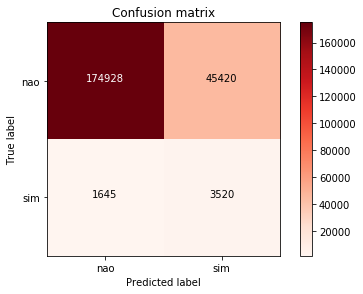

In [25]:
cnf_matrix_tra = confusion
#confusion_matrix(y_test, y_pre)

print("Recall metric in the test dataset: {}%".format(100*cnf_matrix_tra[1,1]/(cnf_matrix_tra[1,0]+cnf_matrix_tra[1,1])))
print("Precision metric in the test dataset: {}%".format(100*cnf_matrix_tra[1,1]/(cnf_matrix_tra[0,1]+cnf_matrix_tra[1,1])))

class_names = ["nao","sim"]
plt.figure()
plot_confusion_matrix(cnf_matrix_tra , classes=class_names, title='Confusion matrix')
plt.show() 


### Importância das Variáveis

[Índice](#Índice)


In [41]:
df_feature_importance = pd.DataFrame({'Variaveis':Var,'Importancia':rf.feature_importances_})
df_feature_importance.sort_values('Importancia', ascending = False)

Variaveis  Importancia
1                TED_VL_TOTAL     0.311491
22                 TED_Q_m4_T     0.166764
7                  MEDIANA_m4     0.086014
12                 MEDIANA_m3     0.067382
20                 MEDIANA_m2     0.063315
8                  MEDIANA_m1     0.053399
0                    VR_RENDA     0.052953
16  CD_CATEGORIA_PROFISSIONAL     0.027062
3                   TEMPO_MOV     0.023402
6                   MIN_CONTA     0.018134
17       Saldo_Medio_HIPERFUN     0.016747
2         Saldo_Medio_RENDAFI     0.012929
13              VL_TOTAL_REST     0.011926
11                  SOMA_REST     0.011711
9             Resgate_RENDAFI     0.011441
4             Saldo_Medio_CDB     0.010261
10             FOLHA_VL_total     0.009727
18            CD_ESTADO_CIVIL     0.008867
5                  QTD_CONTAS     0.008028
24         Saldo_Medio_OUTROS     0.006102
19        ANOS_COM_RESTRITIVO     0.005956
14                Resgate_CDB     0.004501
15                VL_MIN_REST     0.004368
23       Saldo_Medio_MULTIMER     0.004336
21          Saldo_Medio_ACOES     0.003185

In [45]:
df_feature_importance.to_csv('df_feature_importance.csv')

### Teste para diferentes limiares da probabilidade de churn

[Índice](#Índice)


In [29]:
predict_proba = rf.predict_proba(x_test)
predict = rf.predict(x_test)

x_test2 = x_test[:][:]
x_test2['prob'] = [x[1] for x in predict_proba]
x_test2['predict'] = [x for x in predict]
x_test2['churn'] = y_test
x_test2.head()

x_test2['prob_40'] = False
x_test2['prob_40'][x_test2['prob'] > 0.4] = True

x_test2['prob_60'] = False
x_test2['prob_60'][x_test2['prob'] > 0.6] = True

x_test2['prob_70'] = False
x_test2['prob_70'][x_test2['prob'] > 0.7] = True

x_test2['prob_80'] = False
x_test2['prob_80'][x_test2['prob'] > 0.8] = True

x_test2['prob_90'] = False
x_test2['prob_90'][x_test2['prob'] > 0.9] = True

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarnin

### Corte em 40% da 'predict_proba'

[Índice](#Índice)


-------------- CORTE EM 40% --------------


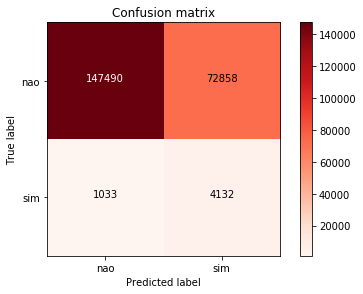

Accuracy: 0.6723426143947355
Precision: 0.053669307702299
Recall: 0.8
F1-score: 0.10059034751384578


In [30]:
print('-------------- CORTE EM 40% --------------')
cnf_matrix_tra = confusion_matrix(x_test2['churn'], x_test2['prob_40'])

classes = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix_tra , classes=class_names, title='Confusion matrix')
plt.show()

print("Accuracy:",metrics.accuracy_score(x_test2['churn'], x_test2['prob_40']))
print("Precision:",metrics.precision_score(x_test2['churn'], x_test2['prob_40']))
print("Recall:",metrics.recall_score(x_test2['churn'], x_test2['prob_40']))
print("F1-score:",metrics.f1_score(x_test2['churn'], x_test2['prob_40']))

### Corte em 60%

[Índice](#Índice)


-------------- CORTE EM 60% --------------


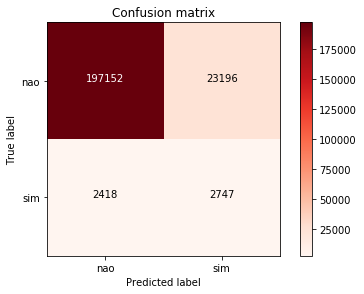

Accuracy: 0.8864189647603464
Precision: 0.10588598080407047
Recall: 0.5318489835430784
F1-score: 0.17661051819467666


In [31]:
print('-------------- CORTE EM 60% --------------')
cnf_matrix_tra = confusion_matrix(x_test2['churn'], x_test2['prob_60'])

classes = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix_tra , classes=class_names, title='Confusion matrix')
plt.show()

print("Accuracy:",metrics.accuracy_score(x_test2['churn'], x_test2['prob_60']))
print("Precision:",metrics.precision_score(x_test2['churn'], x_test2['prob_60']))
print("Recall:",metrics.recall_score(x_test2['churn'], x_test2['prob_60']))
print("F1-score:",metrics.f1_score(x_test2['churn'], x_test2['prob_60']))

### Corte em 70%

[Índice](#Índice)


-------------- CORTE EM 70% --------------


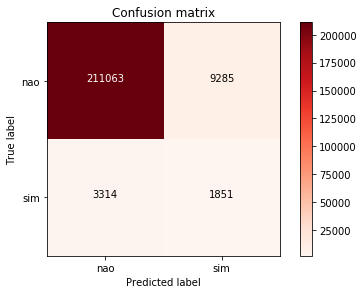

Accuracy: 0.9441318238859844
Precision: 0.1662176724137931
Recall: 0.3583736689254598
F1-score: 0.227102631740384


In [32]:
print('-------------- CORTE EM 70% --------------')
cnf_matrix_tra = confusion_matrix(x_test2['churn'], x_test2['prob_70'])

classes = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix_tra , classes=class_names, title='Confusion matrix')
plt.show()

print("Accuracy:",metrics.accuracy_score(x_test2['churn'], x_test2['prob_70']))
print("Precision:",metrics.precision_score(x_test2['churn'], x_test2['prob_70']))
print("Recall:",metrics.recall_score(x_test2['churn'], x_test2['prob_70']))
print("F1-score:",metrics.f1_score(x_test2['churn'], x_test2['prob_70']))

### Corte em 80%

[Índice](#Índice)


-------------- CORTE EM 80% --------------


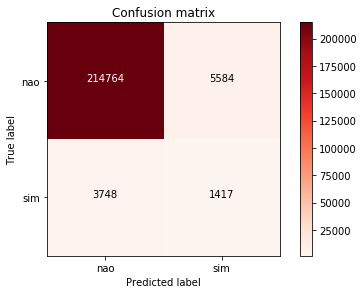

Accuracy: 0.9586187935950478
Precision: 0.20239965719182973
Recall: 0.2743465634075508
F1-score: 0.23294427091895445


In [33]:
print('-------------- CORTE EM 80% --------------')
cnf_matrix_tra = confusion_matrix(x_test2['churn'], x_test2['prob_80'])

classes = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix_tra , classes=class_names, title='Confusion matrix')
plt.show()

print("Accuracy:",metrics.accuracy_score(x_test2['churn'], x_test2['prob_80']))
print("Precision:",metrics.precision_score(x_test2['churn'], x_test2['prob_80']))
print("Recall:",metrics.recall_score(x_test2['churn'], x_test2['prob_80']))
print("F1-score:",metrics.f1_score(x_test2['churn'], x_test2['prob_80']))

### Corte em 90%

[Índice](#Índice)


-------------- CORTE EM 90% --------------


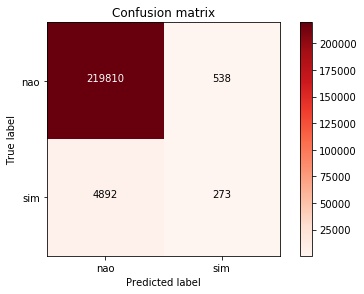

Accuracy: 0.9759215654973328
Precision: 0.3366214549938348
Recall: 0.052855759922555666
F1-score: 0.09136546184738956


In [34]:
print('-------------- CORTE EM 90% --------------')
cnf_matrix_tra = confusion_matrix(x_test2['churn'], x_test2['prob_90'])

classes = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix_tra , classes=class_names, title='Confusion matrix')
plt.show()

print("Accuracy:",metrics.accuracy_score(x_test2['churn'], x_test2['prob_90']))
print("Precision:",metrics.precision_score(x_test2['churn'], x_test2['prob_90']))
print("Recall:",metrics.recall_score(x_test2['churn'], x_test2['prob_90']))
print("F1-score:",metrics.f1_score(x_test2['churn'], x_test2['prob_90']))

## Distribuição da população 'não churn' em relação à probabilidade

[Índice](#Índice)


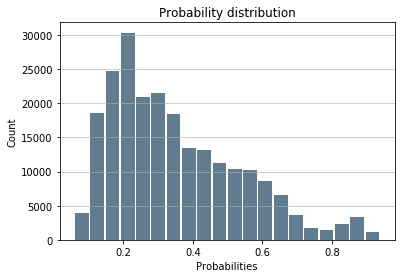

In [35]:
#import matplotlib.pyplot as plt
x_test2['prob'].plot.hist(bins=20, rwidth=0.9,
                   color='#607c8e')
plt.title('Probability distribution')
plt.xlabel('Probabilities')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.75)

## Distribuição da população 'churn' em relação à probabilidade

[Índice](#Índice)

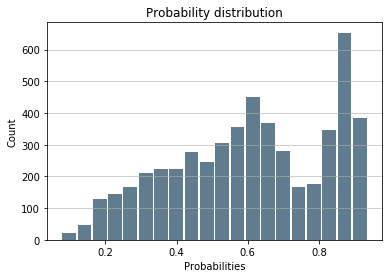

In [36]:
# Histogram to all real churns
x_test3 = x_test2.loc[x_test2['churn'] == True]

#import matplotlib.pyplot as plt
x_test3['prob'].plot.hist(bins=20, rwidth=0.9,
                   color='#607c8e')
plt.title('Probability distribution')
plt.xlabel('Probabilities')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.75)

## Relação entre Recall e Precisão do Modelo

[Índice](#Índice)

/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


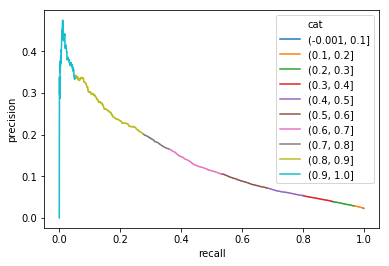

In [37]:
df = pd.DataFrame({'thresholds': np.arange(0,1.01, 0.00001)})
df['cat'] = pd.cut(df['thresholds'], bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], include_lowest=True)
df['VP'] = df.thresholds.apply(lambda x: x_test2[(x_test2.prob > x) & (x_test2.churn == 1)].shape[0])
df['FP'] = df.thresholds.apply(lambda x: x_test2[(x_test2.prob > x) & (x_test2.churn == 0)].shape[0])
df['FN'] = df.thresholds.apply(lambda x: x_test2[(x_test2.prob <= x) & (x_test2.churn == 1)].shape[0])
df['precision'] = df.VP/(df.VP + df.FP)
df['recall'] = df.VP/(df.VP + df.FN)
# df.fillna(0, inplace = True)
df
ax = sns.lineplot(x="recall", y="precision", hue="cat", data=df) 

## Relação entre número de chutes e Churns

[Índice](#Índice)

/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


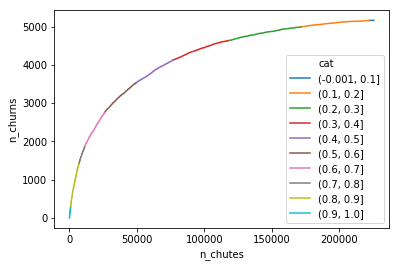

In [43]:
df = pd.DataFrame({'thresholds': np.arange(0,1.01, 0.00001)})
df['cat'] = pd.cut(df['thresholds'], bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], include_lowest=True)
df['VP'] = df.thresholds.apply(lambda x: x_test2[(x_test2.prob > x) & (x_test2.churn == 1)].shape[0])
df['FP'] = df.thresholds.apply(lambda x: x_test2[(x_test2.prob > x) & (x_test2.churn == 0)].shape[0])
df['FN'] = df.thresholds.apply(lambda x: x_test2[(x_test2.prob <= x) & (x_test2.churn == 1)].shape[0])
df['precision'] = df.VP/(df.VP + df.FP)
df['recall'] = df.VP/(df.VP + df.FN)
df['n_churns'] = df.VP
df['n_chutes'] = df.VP + df.FP
# df.fillna(0, inplace = True)
df
ax = sns.lineplot(x="n_chutes", y="n_churns", hue="cat", data=df)

# FIM!!!

## Apêndice

## Função Teste de Parâmetros

Voltar para o tópico:
[Escolha dos melhores parâmetros do modelo a partir do f1-score, precisão e recall](#Escolha-dos-melhores-parâmetros-do-modelo-a-partir-do-f1-score,-precisão-e-recall)

[Índice](#Índice)

In [118]:
def teste_parametros(n_estimadores, profundidade, criterio):
    rf = RandomForestClassifier(n_estimators=n_estimadores, 
                                max_depth=profundidade,
                                criterion=criterio,
                                bootstrap = True,
                                oob_score=True,
                                #n_jobs=-1, # Só usar caso esteja trabalhando na máquina local ou sozinho no Cluster
                                warm_start=True,
                                class_weight="balanced").fit(x_train, y_train) #Class Weight "balanced" -> evento raro

    predicted = rf.predict(x_test)
    classif_report = metrics.classification_report(y_test,predicted) 
    f1score = metrics.f1_score(y_test,predicted)
    logloss = metrics.log_loss(y_test,predicted) #Está dando um erro que precisa ser corrigido para obtenção do Log_loss
    accuracy = metrics.accuracy_score(y_test,predicted)
    precision = metrics.precision_score(y_test,predicted)
    recall = metrics.recall_score(y_test,predicted)
    confusion = metrics.confusion_matrix(y_test,rf.predict(x_test))
    TN, FP    = confusion[0, 0], confusion[0, 1]
    FN, TP    = confusion[1, 0], confusion[1, 1]
    spec = round(TN / float(TN + FP),3)
    sens = round(TP / float(TP + FN),3)
    df_parametros = pd.DataFrame({'Estimadores': [n_estimadores], 
                                   'Profundidade': [profundidade], 
                                   'Criterio': [criterio],
                                   'f1-score':[f1score],
                                   'Log_loss': [logloss],
                                   'prec.':[precision],
                                   'recall':[recall],
                                   'TN':[TN], 
                                   'FP':[FN], 
                                   'FN':[FP], 
                                   'TP':[TP]})
    return df_parametros

### Função para criação da Matriz de Confusão

Voltar para o tópico: 
[Resultados](#Resultados)


[Índice](#Índice)


In [24]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes) 
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label') 